<h1><center>Lab 5 - A5</center></h1>
<h1><center>Evolutionary Algorithms (1)</center></h1>

In [76]:
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Knapsack Problem
- $n$ objects, each has a value ($v$) and a weight ($w$)
- Objective: the knapsack to contain max value without exceeding max weight $W$
$$ \text{maximise } \sum_{i=n}^n v_i x_i $$
$$ \text{subject to } \sum_{i=n}^n v=w_i x_i \leq W  $$
- $x_i=1$ means object $i$ is selected
- $x_i=0$ means object $j$ is not selected

## Knapsack problem: prerequisites
Helper functions for knapsack solution generation and evaluation

In [2]:
# Data loading function

def load_data(file_name):
  '''
    Loads data for the knapsack problem from a file
    Input:
      - file_name: str
    Output:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
  '''
  weights_and_values = []
  with open(file_name) as f:
    # first number = number of records
    size = (int)(f.readline().strip())
    # read index, value, weight for all records
    for i in range(size):
      info = f.readline().strip().split()
      index, value, weight = (int)(info[0]), (int)(info[1]), (int)(info[2])
      weights_and_values.append((weight, value))
    # last number = maximum weight
    max_weight = (int)(f.readline().strip())
  return size, weights_and_values, max_weight

In [3]:
# Knapsack solution evaluation functions

def knapsack_weight(n, weights_and_values, configuration):
  '''
    Returns the total weight of the knapsack for a certain configuration
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
    Output:
      - weight: int
  '''
  weight = 0
  for i in range(n):
    if configuration[i] == 1:
      curr_weight, curr_value = weights_and_values[i]
      weight += curr_weight
  return weight

def knapsack_value(n, weights_and_values, configuration):
  '''
    Returns the total value of the knapsack for a certain configuration
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
    Output:
      - value: int
  '''
  value = 0
  for i in range(n):
    if configuration[i] == 1:
      curr_weight, curr_value = weights_and_values[i]
      value += curr_value
  return value

def knapsack_is_valid(n, weights_and_values, configuration, max_weight):
  '''
    Checks if a certain knapsack configuration is a valid solution
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
      - max_weight: int
    Output:
      - bool
  '''
  weight = knapsack_weight(n, weights_and_values, configuration)
  return weight <= max_weight

def knapsack_fitness(n, weights_and_values, configuration, max_weight):
  '''
    Returns the total value of the knapsack for a certain configuration if it is valid
      or -1 if it is not valid
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
    Output:
      - fitness: int
  '''
  if not knapsack_is_valid(n, weights_and_values, configuration, max_weight):
    return -1
  return knapsack_value(n, weights_and_values, configuration)

In [4]:
# Random knapsack solutions generation functions

def generate_random_configuration(n):
  '''
    Generate a random binary list of size n
    Input:
      - n: int
    Output:
      - list[{0,1}] -> size = n
  '''
  return np.random.randint(2, size=n).tolist()

def generate_random_knapsack(n, weights_and_values, max_weight):
  '''
    Generates a random knapsack configuration and computes its weight, value and fitness
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
    Output:
      - configuration: list[{0,1}] -> size = n
      - weight: int
      - value: int
      - fitness: int
  '''
  configuration = generate_random_configuration(n)
  weight = knapsack_weight(n, weights_and_values, configuration)
  value = knapsack_value(n, weights_and_values, configuration)
  fitness = knapsack_fitness(n, weights_and_values, configuration, max_weight)
  return configuration, weight, value, fitness

def generate_random_valid_knapsack(n, weights_and_values, max_weight):
  '''
    Generates random knapsack configurations until it finds a valid one
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
    Output:
      - configuration: list[{0,1}] -> size = n
      - weight: int
      - value: int
      - fitness: int
  '''
  while True:
    configuration, weight, value, fitness = generate_random_knapsack(n, weights_and_values, max_weight)
    if fitness > 0:
      break
  return configuration, weight, value, fitness

In [181]:
# Display functions

def print_knapsack_solution(n, weights_and_values, max_weight, configuration):
  '''
    Prints a solution of a given knapsack problem
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - configuration: list[{0,1}] -> size = n
    Output: None
  '''
  weight = knapsack_weight(n, weights_and_values, configuration)
  value = knapsack_value(n, weights_and_values, configuration)
  fitness = knapsack_fitness(n, weights_and_values, configuration, max_weight)
  print(f"Solution for knapsack problem of size {n} with max weight {max_weight}:")
  print(f"Configuration: {configuration}")
  print(f"Weight: {weight}; Value: {value}")
  print(f"Fitness: {fitness}")

def lists_to_markdown_table(header, *lists):
  '''
    Returns a string formatted like a markdown table which contains data from the header and the lists
    Input:
      - header: string
      - *lists: varying number of list[] -> size = n
    Output:
      - markdown_table: string
  '''
  markdown_table = header
  n = len(lists[0])
  for i in range(n):
    markdown_table += "|"
    for list in lists:
      markdown_table += f" {list[i]} |"
    markdown_table += "\n"
  return markdown_table

# Evolutionary Algorithm for the Knapsack Problem

## Implementation

In [11]:
# Helper functions

def random_flip_configuration(n, configuration):
  '''
    Flips a random bit in a configuration
    Input:
      - n: int
      - configuration: list[{0,1}] -> size = n
    Output:
      - new_configuration: list[{0,1}] -> size = n
  '''
  flip_position = random.randint(0, n - 1)
  new_configuration = configuration[:]
  if new_configuration[flip_position] == 0:
    new_configuration[flip_position] = 1
  else:
    new_configuration[flip_position] = 0
  return new_configuration

def generate_valid_neighbour(n, weights_and_values, max_weight, configuration):
  '''
    Flips random bits in a configuration until it finds a valid solution
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - configuration: list[{0,1}] -> size = n
    Output:
      - new_configuration: list[{0,1}] -> size = n
  '''
  while True:
    neighbour = random_flip_configuration(n, configuration)
    if knapsack_is_valid(n, weights_and_values, neighbour, max_weight):
      return neighbour

def combine_parents(parent1, parent2):
  '''
    Combines two configurations randomly to create a new one
    Up to a random index i, the values of the first parent are copied,
      after which the values of the second parent are copied
    Input:
      parent1: list[{0,1}]
      parent2: list[{0,1}]
    Output:
      list[{0,1}]
  '''
  point = random.randint(1, len(parent1) - 1)
  return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def select_best_parents(n, weights_and_values, max_weight, population):
  '''
    Selects the best 2 samples from a population
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - population: list[list[{0,1}]]
    Output:
      - parent1: list[{0,1}]
      - parent2: list[{0,1}]
  '''
  parent1 = population[0] # best parent
  fitness1 = knapsack_fitness(n, weights_and_values, parent1, max_weight)
  parent2 = population[1] # second best parent
  fitness2 = knapsack_fitness(n, weights_and_values, parent2, max_weight)

  for i in range(2, len(population)):
    curr_parent = population[i]
    curr_fitness = knapsack_fitness(n, weights_and_values, curr_parent, max_weight)

    if curr_fitness > fitness1:
      fitness2 = fitness1
      parent2 = parent1
      fitness1 = curr_fitness
      parent1 = curr_parent
    
    elif curr_fitness > fitness2:
      fitness2 = curr_fitness
      parent2 = curr_parent

  return parent1, parent2

def get_best_solution(n, weights_and_values, max_weight, population):
  '''
    Returns the best configuration from a list
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - population: list[list[{0,1}]]
    Output:
      - best_solution: list[{0,1}]
  '''
  best_fitness = 0
  best_solution = None
  for i in range(len(population)):
    curr_solution = population[i]
    curr_fitness = knapsack_fitness(n, weights_and_values, curr_solution, max_weight)
    if curr_fitness > best_fitness:
      best_fitness = curr_fitness
      best_solution = curr_solution
  return best_solution

In [15]:
# Evolutionary algorithm for the Knapsack Problem

def knapsack_evolutionary_algorithm(n, weights_and_values, max_weight, population_size, generations):
  '''
    Implements an evolutionary algorithm for the knapsack problem
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - population_size: int
      - generations: int
    Output:
      - best_sol: list[{0,1}] -> size = n
      - best_fitness: int
  '''
  population = []

  for i in range(population_size):
    solution, _, _, _ = generate_random_valid_knapsack(n, weights_and_values, max_weight)
    population.append(solution)

  while generations:
    new_population = []
    
    while len(new_population) < len(population):
      # select best parents
      parent1, parent2 = select_best_parents(n, weights_and_values, max_weight, population)
      # combine parents to create children
      child1, child2 = combine_parents(parent1, parent2)
      # mutate children
      child1 = random_flip_configuration(n, child1)
      child2 = random_flip_configuration(n, child2)
      # add valid children to population
      if knapsack_is_valid(n, weights_and_values, child1, max_weight):
        new_population.append(child1)
      if knapsack_is_valid(n, weights_and_values, child2, max_weight):
        new_population.append(child2)

    population = new_population
    generations = generations - 1

  best_sol = get_best_solution(n, weights_and_values, max_weight, population)
  best_fitness = knapsack_fitness(n, weights_and_values, best_sol, max_weight)
  return best_sol, best_fitness

## Testing

In [28]:
# Testing the Evolutionary Algorithm for the Knapsack Problem for n = 20

# small dataset
n, weights_and_values, max_weight = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab1/input_files/knapsack-20.txt")

population_size = 10
generations = 50

iterations = 100
fitnesses = []
execution_times = []

for i in range(iterations):
  start_time = time.time()
  configuration, current_fitness = knapsack_evolutionary_algorithm(n, weights_and_values, max_weight, population_size, generations)
  end_time = time.time()

  fitnesses.append(current_fitness)
  execution_times.append(end_time - start_time)

average_fitness = np.array(fitnesses).mean()
average_execution_time = np.array(execution_times).mean()

print(f"Average fitness: {average_fitness}")
print(f"Average execution time: {average_execution_time}")

Average fitness: 693.93
Average execution time: 0.03348348379135132


In [29]:
# Testing the Evolutionary Algorithm for the Knapsack Problem for n = 200

# large dataset
n, weights_and_values, max_weight = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab1/input_files/rucsac-200.txt")

population_size = 50
generations = 30

iterations = 10
fitnesses = []
execution_times = []

for i in range(iterations):
  start_time = time.time()
  configuration, current_fitness = knapsack_evolutionary_algorithm(n, weights_and_values, max_weight, population_size, generations)
  end_time = time.time()

  fitnesses.append(current_fitness)
  execution_times.append(end_time - start_time)

average_fitness = np.array(fitnesses).mean()
average_execution_time = np.array(execution_times).mean()

print(f"Average fitness: {average_fitness}")
print(f"Average execution time: {average_execution_time}")

Average fitness: 133044.5
Average execution time: 1.92828209400177


# Travelling Salesman Problem (TSP)
Given a collection of N cities and the cost of travel between each pair of them, the **traveling salesman problem**, or TSP for short, is to find the cheapest way of visiting all of the cities and returning to your starting point.
  
In the standard version, the travel costs are symmetric in the sense that traveling from city X to city Y costs just as much as traveling from Y to X.
  
The solution can be represented as permutation of size N. The cost of a solution is the sum of distances
between cities in the order given by the permutation.

## TSP: prerequisites
Helper functions for TSP solution generation and evaluation

In [3]:
# TSP helper functions

def load_data(file_name):
  '''
    Loads data for TSP from a file (extension .tsp)
    Input:
      - file_name: str
    Output:
      - n: int
      - nodes: dict[int]: tuple[int, int]
  '''
  n = 0
  nodes = {}
  with open(file_name) as f:
    while True:
      line = f.readline()
      # line at beginning of file
      if line[0] >= 'A' and line[0] <= 'Z':
        # get size of dataset
        if line.split()[0] == 'DIMENSION':
          n = int(line.split()[2])
        # end of file
        elif line.strip() == 'EOF':
          break
        else:
          continue
      # line containing tsp data
      else:
        i, x, y = line.split()
        i = int(i)
        x = float(x)
        y = float(y)
        nodes[i] = (x, y)
  return n, nodes

def euclidean_distance(x, y):
  '''
    Computes the euclidean distance between two points in 2D space
    Input:
      - x: tuple[int, int]
      - y: tuple[int, int]
    Output:
      - float
  '''
  return math.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

def tsp_fitness(n, nodes, permutation):
  '''
    Calculates the total length of the tour described by the given permutation
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - permutation: list[int] -> size = n
    Output:
      - length: float
  '''
  length = 0
  for i in range(n - 1):
    length += euclidean_distance(nodes[permutation[i]], nodes[permutation[i+1]])
  length += euclidean_distance(nodes[permutation[-1]], nodes[permutation[0]])
  return length

def generate_random_permutation(n):
  '''
    Generates a random permutation of size n
    Input:
      - n: int
    Output:
      - permutation: list[int] -> size = n
  '''
  permutation = [(1 + i) for i in range(n)]
  random.shuffle(permutation)  
  return permutation

def plot_tsp(nodes, configuration):
  '''
    Plots a TSP tour with matplotlib
    Input: 
      - nodes: dict[int]: tuple[int, int]
      - configuration: list[int]
    Output: None
  '''
  x = [nodes[i][0] for i in configuration]
  x.append(x[0])

  y = [nodes[i][1] for i in configuration]
  y.append(y[0])

  plt.plot(x, y, marker='o', linestyle='-', markersize=8)
  plt.grid()
  plt.show()

# Evolutionary Algorithm for TSP

## Implementation
1. An initial **population** of n randomly selected permutations is chosen. This is the **first generation**.
2. From the population, we select pairs of parents for the next generation using **proportional selection**.  
  This is achieved by assigning each member of the population a "slice of a roulette wheel" proportional to its fitness and spinning the wheel a number of times.
3. Each pair of parents resulted has a **crossover rate**, which gives the probability for one parent to recombine with the other.  
  The crossover can be done using multiple strategies: **Order Crossover (OX)**, **Partially Mapped Crossover (PMX)**.
4. After crossover, a number of children is obtained. Each of these children, then, has a **mutation rate**, which gives the probability for the child to slightly change its configuration.  
  The mutation can be done using multiple strategies: **Insert mutation**, **Inversion mutation**.
5. After obtaining all the children and mutating some of them, a **$(\mu + \lambda)$ selection** takes place.
  If $\mu$ represents the number of parents and $\lambda$ represents the number of children, then the $\mu + \lambda$ individuals are evaluated and the best n distinct permutations are kept.  
  This new population of n values will give the **next generation**.
6. The algorithm is repeated starting from step 2 until **a desired number of generations is reached**.
7. The best value from the last generation is returned as the result.

In [130]:
# Selection functions

def elitism_selection(m, n, nodes, population):
  '''
    Returns the best m permutations from the population to be included automatically in the next generation
    Input:
      - m: int
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - populaton: list[list[int]]
    Output:
      - best_permutations
  '''
  population_copy = population[:]
  best_permutations = []
  while len(best_permutations) < m:
    best_fitness = float("inf")
    best_index = None
    for index in range(len(population_copy)):
      permutation = population_copy[index]
      fitness = tsp_fitness(n, nodes, permutation)
      if fitness < best_fitness:
        best_fitness = fitness
        best_index = index
    best_permutation = population_copy[best_index]
    best_permutations.append(best_permutation)
    population_copy.pop(best_index)
  return best_permutations

def find_slice(weights, value):
  '''
    Given a list which represents the roulette wheel slices and their sizes, returns the index of the slice to which the value belongs
    Input:
      - weights: list[float] -> values in the interval 0 to 1
      - value: float -> in the interval 0 to 1
    Output:
      - index: int
  '''
  # normalize weights to generate distribution
  total_sum = np.sum(weights)
  normalized_weights = [(weight / total_sum) for weight in weights]
  # calculate the cumulative mass function for the discrete distribution
  sum = 0
  cmf = []
  for weight in normalized_weights:
    sum += weight
    cmf.append(sum)
  # find the index of the slice to which the value belongs
  for index in range(len(cmf)):
    if (cmf[index] > value):
      return index
  return index

def select_parents(n, nodes, population):
  '''
    Selects 2 permutations from a given population using proportional selection.
    The proportion is given by the fitness of each permutation.
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - populaton: list[list[int]]
    Output:
      - parent1, parent2: list[int]
  '''
  # configure the roulette wheel slices
  fitnesses = [tsp_fitness(n, nodes, permutation) for permutation in population]
  # the fitnesses are inverted to ensure that lower fitnesses are more highly valued
  weights = [1 / fitness if fitness > 0 else 1e-6 for fitness in fitnesses]

  # choose 2 random numbers and find their corresponding slices
  value1 = np.random.rand()
  index1 = find_slice(weights, value1)
  value2 = np.random.rand()
  index2 = find_slice(weights, value2)
  
  # return the two permutations
  parent1 = population[index1]
  parent2 = population[index2]
  return parent1, parent2

def get_best_permutation(n, nodes, population):
  '''
    Returns the best permutation and best fitness from a list of permutations
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - population: list[list[int]]
    Output:
      - best_permutation: list[int]
      - best_fitness: int
  '''
  best_fitness = float("inf")
  best_permutation = None
  for curr_permutation in population:
    curr_fitness = tsp_fitness(n, nodes, curr_permutation)
    if curr_fitness < best_fitness:
      best_fitness = curr_fitness
      best_permutation = curr_permutation
  return best_permutation, best_fitness


In [203]:
# Variation functions

def order_crossover(parent1, parent2):
  '''
    Recombines the two permutations using the order crossover strategy
    Input:
      - parent1, parent2: list[int]
    Output:
      - child1, child2: list[int]
  '''
  size = len(parent1)
  # choose a subtour of the parents
  subtour_start = random.randint(0, size - 1)
  subtour_end = random.randint(subtour_start, size)
  subtour_parent1 = parent1[subtour_start : subtour_end]
  subtour_parent2 = parent2[subtour_start : subtour_end]
  # generate first child
  child1 = []
  parent1_nodes = subtour_parent1[:]
  parent2_nodes = [node for node in parent2 if node not in subtour_parent1]
  for i in range(0, size):
    if subtour_start <= i < subtour_end:
      child1.append(parent1_nodes.pop(0))
    else:
      child1.append(parent2_nodes.pop(0))
  # generate second child
  child2 = []
  parent2_nodes = subtour_parent2[:]
  parent1_nodes = [node for node in parent1 if node not in subtour_parent2]
  for i in range(0, size):
    if subtour_start <= i < subtour_end:
      child2.append(parent2_nodes.pop(0))
    else:
      child2.append(parent1_nodes.pop(0))
  # return children
  return child1, child2

def partially_mapped_crossover(parent1, parent2):
  '''
    Recombines the two permutations using the partially mapped crossover strategy
    Input:
      - parent1, parent2: list[int]
    Output:
      - child1, child2: list[int]
  '''
  size = len(parent1)
  # choose a subtour of the parents
  subtour_start = random.randint(0, size - 2)
  subtour_end = random.randint(subtour_start + 1, size - 1)  # Ensure at least one element is swapped
  subtour_parent1 = parent1[subtour_start : subtour_end + 1]
  subtour_parent2 = parent2[subtour_start : subtour_end + 1]
  # initialize children as copies of parents
  child1 = parent1[:]
  child2 = parent2[:]
  # swap elements within subtours
  child1[subtour_start : subtour_end + 1] = subtour_parent2
  child2[subtour_start : subtour_end + 1] = subtour_parent1
  # create mappings for conflict resolution
  mapping1 = {subtour_parent2[i]: subtour_parent1[i] for i in range(len(subtour_parent1))}
  mapping2 = {subtour_parent1[i]: subtour_parent2[i] for i in range(len(subtour_parent2))}
  # complete with cities from the original parents if there are conflicts
  for i in range(size):
    if not (subtour_start <= i <= subtour_end):  # Only check the non-subtour positions
      # resolve conflicts for first child
      element1 = child1[i]
      while element1 in subtour_parent2:
        element1 = mapping1[element1]
      child1[i] = element1
      # resolve conflicts for second child
      element2 = child2[i]
      while element2 in subtour_parent1:
        element2 = mapping2[element2]
      child2[i] = element2
  # return children
  return child1, child2


def recombine_parents(parent1, parent2, crossover_rate, strategy):
  '''
    Recombines the two permutations with a given probability using the specified strategy
    Input:
      - parent1, parent2: list[int]
      - crossover_rate: float -> in the interval 0 to 1
      - strategy: string {"OX", "PMX"}
    Output:
      - child1, child2: list[int]
  '''
  crossover_chance = np.random.rand()
  if crossover_chance < crossover_rate:
    # recombine parents to create children
    if strategy == "OX":
      return order_crossover(parent1, parent2)
    if strategy == "PMX":
      return partially_mapped_crossover(parent1, parent2)
  else:
    # the children are identical to the parents
    return parent1, parent2

def insert_mutation(child):
  '''
    Mutates a permutation using the insert mutation strategy
    Input:
      - child: list[int]
    Output:
      - mutated_child: list[int]
  '''
  position1 = random.randint(0, len(child) - 2)
  position2 = random.randint(position1 + 1, len(child) - 1)
  mutated_child = child[:position1 + 1]
  mutated_child.append(child[position2])
  for index in range(position1 + 1, len(child)):
    if index != position2:
      mutated_child.append(child[index])
  return mutated_child

def inversion_mutation(child):
  '''
    Generates a mutation by inverting a subtour of the original permutation
    Input:
      - child: list[int]
    Output:
      - mutated_child: list[int]
  '''
  position1 = random.randint(0, len(child) - 2)
  position2 = random.randint(position1 + 1, len(child) - 1)
  mutated_child = child[:position1] + child[position1:position2 + 1][::-1] + child[position2 + 1:]
  return mutated_child

def mutate_child(child, mutation_rate, strategy):
  '''
    Mutates a permutation with a given probability using the specified strategy
    Input:
    - child: list[int]
    - mutation_rate: float -> in the interval 0 to 1
    - strategy: string {"IsM", "IvM"}
    Output:
      - mutated_child: list[int]
  '''
  mutation_chance = np.random.rand()
  if mutation_chance < mutation_rate:
    # mutate child
    if strategy == "IsM":
      return insert_mutation(child)
    if strategy == "IvM":
      return inversion_mutation(child)
  else:
    # child remains unchanged
    return child

In [209]:
# Evolutionary algorithm for the Travelling Salesman Problem

def tsp_evolutionary_algorithm(n, nodes, population_size=50, generations=100, elitism_size=None, crossover_rate=0.85, crossover_strategy="PMX", mutation_rate=0.2, mutation_strategy="IvM"):
  '''
    Implements an evolutionary algorithm for the travelling salesman problem
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - population_size: int
      - generations: int
      - elitism_size: int
      - crossover_rate: float -> in the interval 0 to 1
      - crossover_strategy: string {"OX", "PMX"}
      - mutation_rate: float -> in the interval 0 to 1
      - mutation_strategy: string {"IsM", "IvM"}
    Output:
      - best_permutation: list[int]
      - best_fitness: int
  '''
  # initialize elitism_size to 5% of population
  if elitism_size is None:
    elitism_size = max(1, int(0.05 * population_size))
  
  # initialize population (first generation)
  population = []
  while len(population) < population_size:
    permutation = generate_random_permutation(n)
    population.append(permutation)

  # compute the next generations
  while generations:
    # perform elitism selection
    next_generation = elitism_selection(elitism_size, n, nodes, population)
    # fill the new generation with children
    while len(next_generation) < population_size:
      # select parents
      parent1, parent2 = select_parents(n, nodes, population)
      # recombine parents to create children
      child1, child2 = recombine_parents(parent1, parent2, crossover_rate, crossover_strategy)
      # mutate children
      child1 = mutate_child(child1, mutation_rate, mutation_strategy)
      child2 = mutate_child(child2, mutation_rate, mutation_strategy)
      # add children to next generation
      next_generation.append(child1)
      next_generation.append(child2)
    # select new population
    population = next_generation
    generations = generations - 1

  # return best permutation from the final generation
  best_permutation, best_fitness = get_best_permutation(n, nodes, population)
  return best_permutation, best_fitness

def tsp_evolutionary_algorithm_n_times (m, n, nodes, population_size=50, generations=100, elitism_size=None, crossover_rate=0.85, crossover_strategy="PMX", mutation_rate=0.2, mutation_strategy="IvM"):
  '''
    Runs the evolutionary algorithm for the TSP m times and returns the best solutions found
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - population_size: int
      - generations: int
      - elitism_size: int
      - crossover_rate: float -> in the interval 0 to 1
      - crossover_strategy: string {"OX", "PMX"}
      - mutation_rate: float -> in the interval 0 to 1
      - mutation_strategy: string {"IsM", "IvM"}
    Output:
      - best_solutions: list[int]
  '''
  best_solutions = []
  for step in range(m):
    _, best_evaluated = tsp_evolutionary_algorithm(n, nodes, population_size=population_size, generations=generations, elitism_size=elitism_size, crossover_rate=crossover_rate, crossover_strategy=crossover_strategy, mutation_rate=mutation_rate, mutation_strategy=mutation_strategy)
    best_solutions.append(best_evaluated)
  return best_solutions

## Testing

Solution to TSP for 101 nodes:
Fitness: 1988.372712623453
Route found:


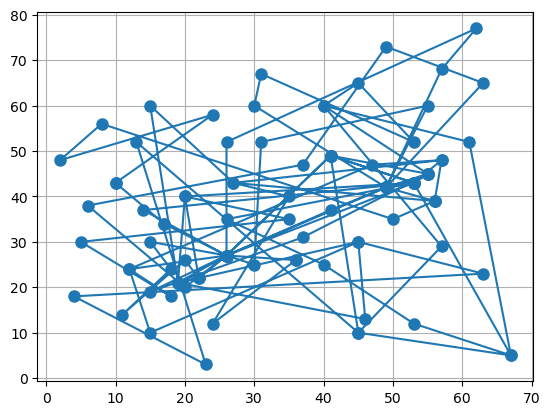

Solution to TSP for 9152 nodes:
Fitness: 72670585.73834878


In [189]:
# Testing evolutionary algorithm for the two datasets

# n = 101
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

permutation, fitness = tsp_evolutionary_algorithm(n, nodes)

print(f"Solution to TSP for {n} nodes:")
print(f"Fitness: {fitness}")

print("Route found:")
plot_tsp(nodes, permutation)

# n = 9152
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/ar9152.tsp")

_, fitness = tsp_evolutionary_algorithm(n, nodes, generations=10)

print(f"Solution to TSP for {n} nodes:")
print(f"Fitness: {fitness}")

Solution to TSP for 101 nodes:
Fitness: 1314.093670810564
Route found:


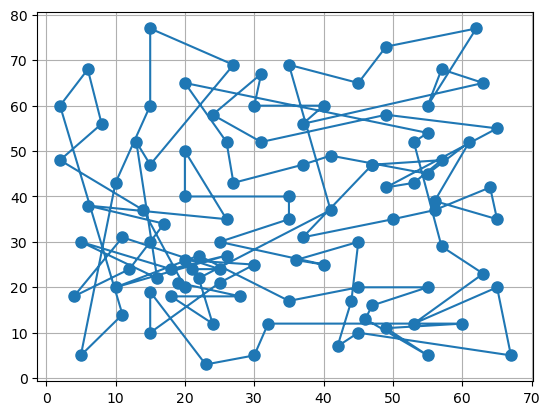

In [207]:
# Testing evolutionary algorithm for the best parameters

n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

permutation, fitness = tsp_evolutionary_algorithm(n, nodes, population_size=50, generations=1500, mutation_rate=0.3)

print(f"Solution to TSP for {n} nodes:")
print(f"Fitness: {fitness}")

print("Route found:")
plot_tsp(nodes, permutation)

## Comparative analysis

In [210]:
# Testing algorithm for different values of population_size and generations

# small dataset
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

population_size_options = [10, 30, 50, 100]
generations_options = [10, 50, 100, 500]

# total expermients: 4 * 4 = 16

population_size_list = []
generations_list = []

fitness_list = []
execution_time_list = []

for population_size in population_size_options:
  for generations in generations_options:
    # perform 5 experiments for given values
    start_time = time.time()
    best_fitnesses = tsp_evolutionary_algorithm_n_times (5, n, nodes, population_size=population_size, generations=generations)
    end_time = time.time()

    average_fitness = np.array(best_fitnesses).mean()
    average_execution_time = (end_time - start_time) / 5

    population_size_list.append(population_size)
    generations_list.append(generations)
    fitness_list.append(average_fitness)
    execution_time_list.append(average_execution_time)

In [212]:
# display experiment results in markdown table

header = "| Population size | Generations | Fitness | Execution time |\n"
header += "|---|---|---|---|\n"
markdown_table = lists_to_markdown_table(header, population_size_list, generations_list, fitness_list, execution_time_list)

| Population size | Generations | Fitness | Execution time |
|---|---|---|---|
| 10 | 10 | 3099.8826731552317 | 0.015845608711242676 |
| 10 | 50 | 2759.5299110337 | 0.08014647960662842 |
| 10 | 100 | 2626.861313972408 | 0.15163831710815429 |
| 10 | 500 | 1898.347055092337 | 0.8008482933044434 |
| 30 | 10 | 3007.1356395421208 | 0.11273877620697022 |
| 30 | 50 | 2702.239070869144 | 0.5482296466827392 |
| 30 | 100 | 2549.3423520448714 | 1.098254346847534 |
| 30 | 500 | 2217.9345216781703 | 5.913468313217163 |
| 50 | 10 | 2968.304969892888 | 0.3132194995880127 |
| 50 | 50 | 2641.4059985730455 | 1.4487374782562257 |
| 50 | 100 | 2514.098375992414 | 3.0534096479415895 |
| 50 | 500 | 1931.677900766518 | 14.879843616485596 |
| 100 | 10 | 2887.311500033541 | 1.2142497539520263 |
| 100 | 50 | 2563.3162643747132 | 6.09339816570282 |
| 100 | 100 | 2376.875041017561 | 11.656143045425415 |
| 100 | 500 | 1525.8181665095558 | 60.94702713489532 |

### Experiment findings:
- We observe that both increasing the population and the generation sizes yields better overall results, at the cost of computational power.  
- The number of generations, in particular, seems to contribute most to the fitness of the solution, with solution quality increasing singificantly over a larger generation size.
- For the following experiments, we will use a population size of 50 and a generation number of 200 to ensure both solution quality and reasonable execution time.

In [213]:
# Testing algorithm for different values of elitism_size, crossover_rate and mutation_rate

# small dataset
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

elitism_size_options = [None, 5, 10]
crossover_rate_options = [0.7, 0.8, 0.9, 1]
mutation_rate_options = [0.1, 0.2, 0.3, 0.5]

# total expermients: 3 * 4 * 4 = 48

elitism_size_list = []
crossover_rate_list = []
mutation_rate_list = []

fitness_list = []
execution_time_list = []

for elitism_size in elitism_size_options:
  for crossover_rate in crossover_rate_options:
    for mutation_rate in mutation_rate_options:
      # perform 5 experiments for given values
      start_time = time.time()
      best_fitnesses = tsp_evolutionary_algorithm_n_times (5, n, nodes, population_size=50, generations=200, elitism_size=elitism_size, crossover_rate=crossover_rate, mutation_rate=mutation_rate)
      end_time = time.time()

      average_fitness = np.array(best_fitnesses).mean()
      average_execution_time = (end_time - start_time) / 5

      elitism_size_list.append(elitism_size)
      crossover_rate_list.append(crossover_rate)
      mutation_rate_list.append(mutation_rate)
      fitness_list.append(average_fitness)
      execution_time_list.append(average_execution_time)

In [217]:
# display experiment results in markdown table

header = "| Elitism size | Crossover rate | Mutation rate | Fitness | Execution time |\n"
header += "|---|---|---|---|---|\n"
markdown_table = lists_to_markdown_table(header, elitism_size_list, crossover_rate_list, mutation_rate_list, fitness_list, execution_time_list)

| Elitism size | Crossover rate | Mutation rate | Fitness | Execution time |
|---|---|---|---|---|
| None | 0.7 | 0.1 | 2207.784418239362 | 11.557575988769532 |
| None | 0.7 | 0.2 | 2189.016497610041 | 12.062565851211549 |
| None | 0.7 | 0.3 | 2243.787531649141 | 10.39588279724121 |
| None | 0.7 | 0.5 | 2198.9667851940235 | 10.64518313407898 |
| None | 0.8 | 0.1 | 2249.567205690883 | 17.912374877929686 |
| None | 0.8 | 0.2 | 2287.666666519742 | 13.244880151748657 |
| None | 0.8 | 0.3 | 2297.393081475382 | 11.038106107711792 |
| None | 0.8 | 0.5 | 2302.0144104564097 | 14.537247657775879 |
| None | 0.9 | 0.1 | 2281.62480002384 | 12.42111496925354 |
| None | 0.9 | 0.2 | 2314.4532164047846 | 12.55078091621399 |
| None | 0.9 | 0.3 | 2324.0935401398137 | 11.44626717567444 |
| None | 0.9 | 0.5 | 2335.131684262505 | 11.306146669387818 |
| None | 1 | 0.1 | 2262.0789704141434 | 11.37134108543396 |
| None | 1 | 0.2 | 2407.3451974427726 | 11.12127332687378 |
| None | 1 | 0.3 | 2400.105670354676 | 11.037654972076416 |
| None | 1 | 0.5 | 2416.4093181018143 | 11.226848077774047 |
| 5 | 0.7 | 0.1 | 1900.5445490999184 | 12.191950798034668 |
| 5 | 0.7 | 0.2 | 1989.48438901268 | 11.998857021331787 |
| 5 | 0.7 | 0.3 | 1978.419691767891 | 12.266981410980225 |
| 5 | 0.7 | 0.5 | 1928.903208375094 | 12.126295137405396 |
| 5 | 0.8 | 0.1 | 1908.7440273966943 | 11.912357091903687 |
| 5 | 0.8 | 0.2 | 1984.0043788181295 | 12.341838359832764 |
| 5 | 0.8 | 0.3 | 1964.0971472839385 | 11.918189287185669 |
| 5 | 0.8 | 0.5 | 1949.7002278171622 | 12.100713729858398 |
| 5 | 0.9 | 0.1 | 1874.003842336087 | 12.071798038482665 |
| 5 | 0.9 | 0.2 | 1995.3050859348891 | 12.17025876045227 |
| 5 | 0.9 | 0.3 | 1945.5083903925733 | 12.44767165184021 |
| 5 | 0.9 | 0.5 | 2079.338250930148 | 12.618395233154297 |
| 5 | 1 | 0.1 | 1859.8620581716928 | 12.32552194595337 |
| 5 | 1 | 0.2 | 1944.0543144817318 | 12.625556993484498 |
| 5 | 1 | 0.3 | 2131.46965571194 | 12.76729121208191 |
| 5 | 1 | 0.5 | 2081.2588903238084 | 12.543000745773316 |
| 10 | 0.7 | 0.1 | 1824.0671403024542 | 12.677629375457764 |
| 10 | 0.7 | 0.2 | 1830.4222388743942 | 13.16392822265625 |
| 10 | 0.7 | 0.3 | 1795.6306238854347 | 12.772860860824585 |
| 10 | 0.7 | 0.5 | 1785.5628624128792 | 12.825023174285889 |
| 10 | 0.8 | 0.1 | 1790.8147557804878 | 13.120934677124023 |
| 10 | 0.8 | 0.2 | 1806.805755610736 | 14.356847429275513 |
| 10 | 0.8 | 0.3 | 1764.4372905736109 | 17.26100640296936 |
| 10 | 0.8 | 0.5 | 1807.7106682729664 | 12.674487924575805 |
| 10 | 0.9 | 0.1 | 1730.1528774550152 | 12.941165781021118 |
| 10 | 0.9 | 0.2 | 1778.3481479900026 | 14.411375474929809 |
| 10 | 0.9 | 0.3 | 1824.4279218541553 | 15.631962490081786 |
| 10 | 0.9 | 0.5 | 1866.094213946438 | 13.72008295059204 |
| 10 | 1 | 0.1 | 1821.7321364452778 | 17.61329002380371 |
| 10 | 1 | 0.2 | 1830.8839928172954 | 15.537994050979615 |
| 10 | 1 | 0.3 | 1839.0589358036075 | 15.872816514968871 |
| 10 | 1 | 0.5 | 1934.2747931890208 | 14.387600517272949 |

In [218]:
# Analyse fitness by each parameter option

elitism_size_options = [None, 5, 10]
crossover_rate_options = [0.7, 0.8, 0.9, 1]
mutation_rate_options = [0.1, 0.2, 0.3, 0.5]

# average fitness and average time by elitism_size
for elitism_size in elitism_size_options:
  fitnesses = []
  execution_times = []
  for i in range(48):
    if elitism_size_list[i] == elitism_size:
      fitnesses.append(fitness_list[i])
      execution_times.append(execution_time_list[i])
  average_fitness = np.array(fitnesses).mean()
  average_execution_time = np.array(execution_times).mean()
  # print results
  print(f"Elitism size: {elitism_size}, average fitness: {average_fitness}, average execution time: {average_execution_time}")

print()

# average fitness and average time by crossover_rate
for crossover_rate in crossover_rate_options:
  fitnesses = []
  execution_times = []
  for i in range(48):
    if crossover_rate_list[i] == crossover_rate:
      fitnesses.append(fitness_list[i])
      execution_times.append(execution_time_list[i])
  average_fitness = np.array(fitnesses).mean()
  average_execution_time = np.array(execution_times).mean()
  # print results
  print(f"Crossover rate: {crossover_rate}, average fitness: {average_fitness}, average execution time: {average_execution_time}")

print()

# average fitness and average time by mutation_rate
for mutation_rate in mutation_rate_options:
  fitnesses = []
  execution_times = []
  for i in range(48):
    if mutation_rate_list[i] == mutation_rate:
      fitnesses.append(fitness_list[i])
      execution_times.append(execution_time_list[i])
  average_fitness = np.array(fitnesses).mean()
  average_execution_time = np.array(execution_times).mean()
  # print results
  print(f"Mutation rate: {mutation_rate}, average fitness: {average_fitness}, average execution time: {average_execution_time}")

Elitism size: None, average fitness: 2294.8399371237083, average execution time: 12.117202734947206
Elitism size: 5, average fitness: 1969.6686317408985, average execution time: 12.276667338609695
Elitism size: 10, average fitness: 1814.401522200861, average execution time: 14.310562866926194

Crossover rate: 0.7, average fitness: 1989.3824947019427, average execution time: 12.05706114768982
Crossover rate: 0.8, average fitness: 2009.4129679746784, average execution time: 13.534915308157602
Crossover rate: 0.9, average fitness: 2029.0401643058542, average execution time: 12.811418342590331
Crossover rate: 1, average fitness: 2077.3778277714823, average execution time: 13.202515788873034

Mutation rate: 0.1, average fitness: 1975.9147317796544, average execution time: 13.176421221097309
Mutation rate: 0.2, average fitness: 2029.815823459767, average execution time: 12.965513046582542
Mutation rate: 0.3, average fitness: 2042.3691234076803, average execution time: 12.904724240303038
Muta

### Experiment findings:
We observe that all the considered variables influence the performance of the algorithm.
- For elitism size, it seems that higher values are preffered to ensure better solution quality.
- For crossover rate, a medium value of around 0.7 seems to be ideal.
- For mutation rate, a lower value of around 0.1 is prefered.  
  
Taking these into consideration, we will chose the desired values for our runs to be: elitism_size = 10, crossover_rate = 0.7 and mutation_rate = 0.1.
- We see that for these values our average fitness is around 1824, which is a good value.

In [219]:
# Testing algorithm for different types of crossover_strategy and mutation_strategy

# small dataset
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

crossover_strategy_options = ["OX", "PMX"]
mutation_strategy_options = ["IsM", "IvM"]

# total expermients: 2 * 2 = 4

crossover_strategy_list = []
mutation_strategy_list = []

fitness_list = []
execution_time_list = []

for crossover_strategy in crossover_strategy_options:
  for mutation_strategy in mutation_strategy_options:
    # perform 5 experiments for given values
    start_time = time.time()
    best_fitnesses = tsp_evolutionary_algorithm_n_times (5, n, nodes, elitism_size=10, crossover_rate=0.7, crossover_strategy=crossover_strategy, mutation_rate=0.1, mutation_strategy=mutation_strategy)
    end_time = time.time()

    average_fitness = np.array(best_fitnesses).mean()
    average_execution_time = (end_time - start_time) / 5

    crossover_strategy_list.append(crossover_strategy)
    mutation_strategy_list.append(mutation_strategy)
    fitness_list.append(average_fitness)
    execution_time_list.append(average_execution_time)

In [222]:
# display experiment results in markdown table

header = "| Crossover strategy | Mutation strategy | Fitness | Execution time |\n"
header += "|---|---|---|---|\n"
markdown_table = lists_to_markdown_table(header, crossover_strategy_list, mutation_strategy_list, fitness_list, execution_time_list)

| Crossover strategy | Mutation strategy | Fitness | Execution time |
|---|---|---|---|
| OX | IsM | 2234.520560373302 | 6.31827826499939 |
| OX | IvM | 2046.51161567584 | 6.130096054077148 |
| PMX | IsM | 2139.6698291562143 | 5.879773139953613 |
| PMX | IvM | 2225.2082364835437 | 6.053972387313843 |

### Experiment findings:
- Generally, all strategies yield decent results to the TSP.
- What is interesting is that certain combinations of crossover and mutation strategies perform better than others.
- We see the best performance for the algorithm when using Order Crossover alongside Inversion Mutation. The second best performance seems to be, however, Partially Mapped Crossover alongside Insert sutation.

## Conclusions
The genetic algorithm is a good heuristic applied as a solution to the TSP problem.
- The algorithm is **highly customizable**. There are several strategies which can be employed in both the *selection process* and the *variation process*. There are also several parameters which dictate the performance of the algorithm.
- Solution quality generally improves with a bigger number of iterations (generations), but there are also other ways to ensure solution quality.  
- **Exploration** can be achieved through *increasing the crossover and mutation rates*.  
- **Explotation**, on the other hand, can be achieved through *elitism* (transfering some of the best solutions from one generation to another).  
  
The only major drawback is the fact that (my current implementation) might require significant computational resources to find the best solutions to the problem. 